<h1 style='text-align: center;'> B-cell Epitope Immune Response | Rafael Almazan </h1>
<h3 style='text-align: center;'> Deep Learning Models </h3>

As we saw with the basic machine learning models, we did not get very good results. We will now try to use deep learning models on the protein and peptide sequences to see if we are able to detect patterns in our data and predict these b-cell epitopes.

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# # Loading data using google colab

# from google.colab import drive
# drive.mount('/content/drive')

# df = pd.read_csv('drive/MyDrive/Bcell_Epitopes/bcell_cleaned.csv')
# df_sample = df.groupby('antibody_activity', group_keys=False).apply(lambda x: x.sample(min(len(x), 1000), random_state=42))

# df_test = pd.read_csv('drive/MyDrive/Bcell_Epitopes/sars_cleaned.csv')

# all = pd.read_csv('drive/MyDrive/Bcell_Epitopes/bcell_sars_cleaned.csv'

To start, we will first load our data. For this notebook, we will be using both the general b-cell data to train our models and will be testing on our SARS dataset. This will be to see if we are able to predict the b-cell epitopes for unseen viruses such as the SARS virus.

We will also load the combined dataset just to see if we are able to predict the b-cell epitopes for the combined dataset. To verify that we see the same pattern as previously seen in the past notebooks.

In [3]:
# Loading data using local machine
bcell = pd.read_csv('data/bcell_cleaned.csv')
bcell_sample = bcell.groupby('antibody_activity', group_keys=False).apply(lambda x: x.sample(min(len(x), 1000), random_state=42))
sars = pd.read_csv('data/sars_cleaned.csv')
all = pd.read_csv('data/bcell_sars_cleaned.csv')


Now that we have our data loaded, we will create tensors for our protein and peptide sequences. This will be created by assigning each amino acid a number and then creating a tensor of these numbers. We will also create a tensor for our labels. We will then pad our sequences to make sure that they are all the same length

In [4]:
# creating series of peptide and protein sequences to convert to tensors
prot_seq = bcell_sample['protein_seq']
pep_seq = bcell_sample['peptide_seq']
start = bcell_sample['start_position']
target = bcell_sample['antibody_activity']
mask = bcell_sample['peptide_mask']

prot_seq_test = sars['protein_seq']
pep_seq_test = sars['peptide_seq']
start_test = sars['start_position']
target_test = sars['antibody_activity']
mask_test = sars['peptide_mask']

# amino acids dictionary
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# convert peptide sequence to tensor
pep_tensor_bcell = [torch.tensor([amino_acids.index(aa) for aa in seq], dtype=torch.long) for seq in pep_seq]
prot_tensor_bcell = [torch.tensor([amino_acids.index(aa) for aa in seq], dtype=torch.long) for seq in prot_seq]
labels_tensor_bcell = torch.tensor(target, dtype=torch.long).to(device)

pep_tensor_sars = [torch.tensor([amino_acids.index(aa) for aa in seq], dtype=torch.long) for seq in pep_seq_test]
prot_tensor_sars = [torch.tensor([amino_acids.index(aa) for aa in seq], dtype=torch.long) for seq in prot_seq_test]
labels_tensor_sars = torch.tensor(target_test, dtype=torch.long).to(device)

# pad peptide sequence to the same length
pep_tensor_bcell = nn.utils.rnn.pad_sequence(pep_tensor_bcell, batch_first=True).to(device)
prot_tensor_bcell = nn.utils.rnn.pad_sequence(prot_tensor_bcell, batch_first=True).to(device)
pep_tensor_sars = nn.utils.rnn.pad_sequence(pep_tensor_sars, batch_first=True).to(device)
prot_tensor_sars = nn.utils.rnn.pad_sequence(prot_tensor_sars, batch_first=True).to(device)

We will do the same to our combined dataset.

In [5]:
# take an equal sample of Epitopes and Non-Epitopes
all_sample = all.groupby('antibody_activity', group_keys=False).apply(lambda x: x.sample(min(len(x), 1000), random_state=42))

X = all_sample[['peptide_seq', 'protein_seq']]
y = all_sample['antibody_activity']

# split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

prot_train = X_train['protein_seq']
pep_train = X_train['peptide_seq']
prot_test = X_test['protein_seq']
pep_test = X_test['peptide_seq']

# amino acid dictionary
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# convert peptide sequence to tensor
pep_train = [torch.tensor([amino_acids.index(aa) for aa in seq], dtype=torch.long) for seq in pep_train]
prot_train = [torch.tensor([amino_acids.index(aa) for aa in seq], dtype=torch.long) for seq in prot_train]
labels_train = torch.tensor(y_train, dtype=torch.long).to(device)

# convert peptide sequence to tensor for test set
pep_test = [torch.tensor([amino_acids.index(aa) for aa in seq], dtype=torch.long) for seq in pep_test]
prot_test = [torch.tensor([amino_acids.index(aa) for aa in seq], dtype=torch.long) for seq in prot_test]
labels_test = torch.tensor(y_test.to_list(), dtype=torch.long).to(device)

# pad peptide sequence to the same length
pep_train = torch.nn.utils.rnn.pad_sequence(pep_train, batch_first=True).to(device)
prot_train = torch.nn.utils.rnn.pad_sequence(prot_train, batch_first=True).to(device)
pep_test = torch.nn.utils.rnn.pad_sequence(pep_test, batch_first=True).to(device)
prot_test = torch.nn.utils.rnn.pad_sequence(prot_test, batch_first=True).to(device)

Now, we will initialize our hyperparameters

In [64]:
# hyperparameters
embedding_dim = 64
hidden_dim = 32
num_layers = 2
num_classes = 2
num_epochs = 10
batch_size = 64
learning_rate = 0.1

## RNN

The first deep learning model we will fit is a simple Recurrent Neural Network. We will use a simple RNN with two hidden layers and the same hyperparameters as above. A recurrent neural network is a type of artificial neural network which uses sequential data. Since our peptide sequences are sequential, we will try and see if a simple RNN will be able to pick up on the patterns in our data.

In [7]:
# define simple RNN model

class RNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes) -> None:
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(20, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        # x shape -> (batch_size, seq_size, input_size)

        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, seq):
        h0 = torch.zeros(self.num_layers, seq.size(0), self.hidden_dim).to(device)

        out, _ = self.rnn(self.embedding(seq), h0)
        # out: batch_size, seq_length, hidden_dim
        # out (N, seq , 32)
        out = out[:, -1, :]
        # out (N, 32)
        out = self.fc(out)
        return out


Now that we have defined our simple RNN, we will define our training function. This function will be used to train our models throughout this notebook. We will use an SGD optimizer as well as cross entropy loss as our loss function. 

In [43]:
# define training and testing function

def train_test(model, num_epochs, batch_size, learning_rate, X, y, X_test, y_test, updates=False):
    '''
    train and test rnn model
    '''
    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    scores = pd.DataFrame()

    for epoch in range(num_epochs):
        loss_sum = 0
        acc_sum = 0
        acc_sum_test = 0
        for i in range(0, len(X), batch_size):
            # print(f'/rEpoch = {epoch}', end='')
            batch_X = X[i:i+batch_size]
            batch_y = y[i:i+batch_size]
            
            optimizer.zero_grad()
            output_values = model(batch_X)

            loss = criterion(output_values, batch_y)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            
            predicted = torch.argmax(output_values, dim=1)
            acc_sum += (predicted == batch_y).sum().item() / len(batch_y)

        loss_avg = round((loss_sum / (len(X) / batch_size)), 3)
        # acc_avg = round((acc_sum / (len(X) / batch_size)), 3)
        acc_avg = (torch.argmax(model(X), dim=1) == y).sum().item() / len(y)

        predicted_test = torch.argmax(model(X_test), dim=1)
        acc_sum_test = (predicted_test == y_test).sum().item() / len(y_test)
        acc_avg_test = round((acc_sum_test), 3)
        # f1 score for test set positive class
        # f1 = round(f1_score(y_test, predicted_test, pos_label=1), 3)

        if updates == True:
            print(f'Epoch = {epoch+1}, loss = {loss_avg}, acc = {acc_avg*100}, test_acc = {acc_avg_test*100}')
        # scores.loc[epoch, "Epoch"] = epoch + 1
        scores.loc[epoch, 'Training Accuracy'] = acc_avg*100
        scores.loc[epoch, 'Test Accuracy'] = acc_avg_test*100

    scores.plot(kind='line')

    print('Finished Training')
            



In [65]:
# instantiating our simple RNN
rnn = RNN(embedding_dim, hidden_dim, num_layers, num_classes).to(device)

Epoch = 1, loss = 0.31, acc = 50.0, test_acc = 26.1
Epoch = 2, loss = 0.455, acc = 50.0, test_acc = 26.1
Epoch = 3, loss = 0.468, acc = 50.0, test_acc = 26.1
Epoch = 4, loss = 0.479, acc = 50.0, test_acc = 26.1
Epoch = 5, loss = 0.463, acc = 50.0, test_acc = 26.1
Epoch = 6, loss = 0.489, acc = 50.0, test_acc = 26.1
Epoch = 7, loss = 0.49, acc = 50.0, test_acc = 26.1
Epoch = 8, loss = 0.49, acc = 50.0, test_acc = 26.1
Epoch = 9, loss = 0.523, acc = 50.0, test_acc = 26.1
Epoch = 10, loss = 0.558, acc = 50.0, test_acc = 26.1
Epoch = 11, loss = 0.513, acc = 50.0, test_acc = 26.1
Epoch = 12, loss = 0.464, acc = 50.0, test_acc = 26.1
Epoch = 13, loss = 0.464, acc = 50.0, test_acc = 26.1
Epoch = 14, loss = 0.484, acc = 50.0, test_acc = 26.1
Epoch = 15, loss = 0.515, acc = 50.0, test_acc = 26.1
Epoch = 16, loss = 0.503, acc = 50.0, test_acc = 26.1
Epoch = 17, loss = 0.481, acc = 50.0, test_acc = 26.1
Epoch = 18, loss = 0.497, acc = 50.0, test_acc = 26.1
Epoch = 19, loss = 0.488, acc = 50.0, te

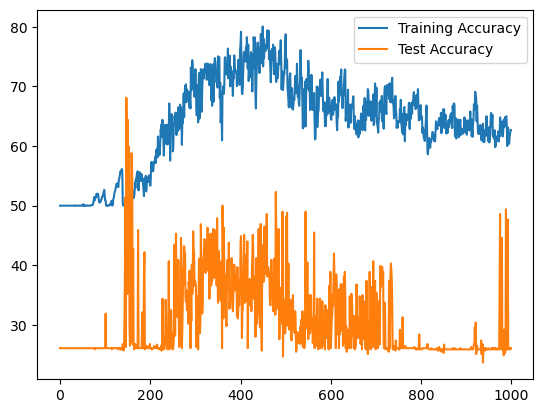

In [66]:
# training and testing simple RNN
train_test(rnn, 1000, batch_size, learning_rate, pep_tensor_bcell, labels_tensor_bcell, pep_tensor_sars, labels_tensor_sars, updates=True)

Wow! we see that the RNN did not learn any generalized information or patterns in the peptide sequences. We see the bcell accuracy increase while the accuracy on the sars set stays the exact same. This means that the RNN is not picking up on any patterns that differentiate between epitopes and non epitopes. The accuracy across the epochs just seems random and unpredictable, without any learning being done. Maybe we need to look at different types of recurrent neural networks. Next, we will try a Long Short Term Memory (LSTM) network.

## LSTM 

The Long Short Term Memory model is a variation of the RNN. It is a type of recurrent neural network that is able to learn patterns in the data and remember them for a longer period of time. The LSTM unit has gates that control the flow of information through the unit. We will try and see if the LSTM is able to learn patterns in our data and predict the b-cell epitopes. The same hyperparameters will be used. Here, we will use a unidirectional LSTM, reading the flow of sequence from left to right.

In [25]:
# define LSTM model
class Epitope_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes) -> None:
        super(Epitope_LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(20, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        # x shape -> (batch_size, seq_size, input_size)

        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, seq):
        h0 = torch.zeros(self.num_layers, seq.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, seq.size(0), self.hidden_dim).to(device)

        out, _ = self.lstm(self.embedding(seq), (h0,c0))
        # out: batch_size, seq_length, hidden_dim
        # out (N, seq , 32)
        out = out[:, -1, :]
        # out (N, 32)
        out = self.fc(out)
        return out

In [48]:
# instantiating our LSTM
lstm = Epitope_LSTM(embedding_dim, hidden_dim, num_layers, num_classes).to(device)

Epoch = 1, loss = 0.597, acc = 50.0, test_acc = 26.1
Epoch = 2, loss = 0.684, acc = 50.0, test_acc = 26.1
Epoch = 3, loss = 0.697, acc = 50.0, test_acc = 26.1
Epoch = 4, loss = 0.7, acc = 50.0, test_acc = 26.1
Epoch = 5, loss = 0.701, acc = 50.0, test_acc = 26.1
Epoch = 6, loss = 0.702, acc = 50.0, test_acc = 26.1
Epoch = 7, loss = 0.702, acc = 50.0, test_acc = 26.1
Epoch = 8, loss = 0.703, acc = 50.0, test_acc = 26.1
Epoch = 9, loss = 0.703, acc = 50.0, test_acc = 26.1
Epoch = 10, loss = 0.703, acc = 50.0, test_acc = 26.1
Epoch = 11, loss = 0.703, acc = 50.0, test_acc = 26.1
Epoch = 12, loss = 0.704, acc = 50.0, test_acc = 26.1
Epoch = 13, loss = 0.704, acc = 50.0, test_acc = 26.1
Epoch = 14, loss = 0.704, acc = 50.0, test_acc = 26.1
Epoch = 15, loss = 0.704, acc = 50.0, test_acc = 26.1
Epoch = 16, loss = 0.704, acc = 50.0, test_acc = 26.1
Epoch = 17, loss = 0.704, acc = 50.0, test_acc = 26.1
Epoch = 18, loss = 0.704, acc = 50.0, test_acc = 26.1
Epoch = 19, loss = 0.704, acc = 50.0, t

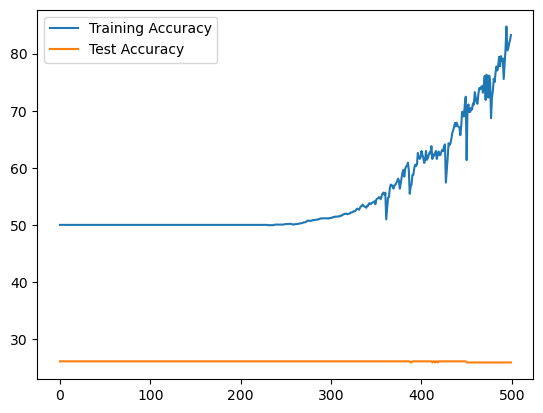

In [44]:
# training and testing LSTM
train_test(lstm, 500, batch_size, 0.1, pep_tensor_bcell, labels_tensor_bcell, pep_tensor_sars, labels_tensor_sars, updates=True)

After training our unidirectional LSTM, we see that after 500 epochs the model learns something about the training set but does not learn anything from the test set. This means that the LSTM is picking up on patterns in the general bcell data but those patterns are not necessarily translating to the SARS data. This is not good because we want our model to be able to predict bcell epitopes for unseen viruses. We will now try a LSTM with a sigmoid activation function.

## LSTM with Sigmoid

Here, we will add another fully connected layer after the LSTM layer. This layer will have a sigmoid activation function. We will also use the same hyperparameters as above.

In [73]:
# define our LSTM with Sigmoid activation function
class Epitope_LSTM_sig(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes) -> None:
        super(Epitope_LSTM_sig, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(20, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        # x shape -> (batch_size, seq_size, input_size)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim*2, 20),
            nn.Sigmoid(),
            nn.Linear(20, num_classes)
        )
    
    def forward(self, seq):
        h0 = torch.zeros(self.num_layers*2, seq.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers*2, seq.size(0), self.hidden_dim).to(device)

        out, _ = self.lstm(self.embedding(seq), (h0,c0))
        # out: batch_size, seq_length, hidden_dim
        # out (N, seq , 32)
        out = out[:, -1, :]
        # out (N, 32)
        out = self.fc(out)
        return out

In [74]:
# instantiating our LSTM with Sigmoid activation function
lstm_sig = Epitope_LSTM_sig(embedding_dim, hidden_dim, num_layers, num_classes).to(device)

Epoch = 1, loss = 0.368, acc = 50.0, test_acc = 26.1
Epoch = 2, loss = 0.514, acc = 50.0, test_acc = 26.1
Epoch = 3, loss = 0.516, acc = 50.0, test_acc = 26.1
Epoch = 4, loss = 0.518, acc = 50.0, test_acc = 26.1
Epoch = 5, loss = 0.519, acc = 50.0, test_acc = 26.1
Epoch = 6, loss = 0.521, acc = 50.0, test_acc = 26.1
Epoch = 7, loss = 0.522, acc = 50.0, test_acc = 26.1
Epoch = 8, loss = 0.524, acc = 50.0, test_acc = 26.1
Epoch = 9, loss = 0.525, acc = 50.0, test_acc = 26.1
Epoch = 10, loss = 0.526, acc = 50.0, test_acc = 26.1
Epoch = 11, loss = 0.528, acc = 50.0, test_acc = 26.1
Epoch = 12, loss = 0.529, acc = 50.0, test_acc = 26.1
Epoch = 13, loss = 0.531, acc = 50.0, test_acc = 26.1
Epoch = 14, loss = 0.532, acc = 50.0, test_acc = 26.1
Epoch = 15, loss = 0.534, acc = 50.0, test_acc = 26.1
Epoch = 16, loss = 0.535, acc = 50.0, test_acc = 26.1
Epoch = 17, loss = 0.537, acc = 50.0, test_acc = 26.1
Epoch = 18, loss = 0.538, acc = 50.0, test_acc = 26.1
Epoch = 19, loss = 0.54, acc = 50.0, 

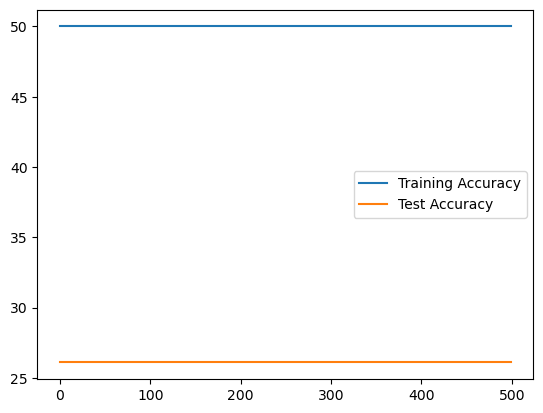

In [75]:
# training and testing LSTM with Sigmoid activation function
train_test(lstm_sig, 500, batch_size, learning_rate, pep_tensor_bcell, labels_tensor_bcell, pep_tensor_sars, labels_tensor_sars, updates=True)

After fitting our LSTM with sigmoid layer, we see that the model does nothing. Both the training and test accuracy stay the same throughout the 500 epochs. This means that the model is not learning anything about the data. We will now try a bidirectional LSTM.

## Bidirectional LSTM

Since the unidirectional LSTM did not pick up on any general patterns for bcell epitopes, we will attempt to use a bidirectional LSTM. This will allow the model to learn patterns in the data from both directions as peptides are bidirectional and do not have one specific flow or direction in their sequence. We will use the same hyperparameters as above.

In [56]:
# defining our bidirectional LSTM model
class Epitope_biLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes) -> None:
        super(Epitope_biLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(20, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True,
                            bidirectional=True)
        # x shape -> (batch_size, seq_size, input_size)

        self.fc = nn.Linear(hidden_dim*2, num_classes)
    
    def forward(self, seq):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers*2, seq.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers*2, seq.size(0), self.hidden_dim).to(device)

        out, _ = self.lstm(self.embedding(seq), (h0,c0))
        # out: batch_size, seq_length, hidden_dim
        # out (N, seq , 32)
        out = out[:, -1, :]
        # out (N, 32)
        out = self.fc(out)
        return out

In [60]:
biLSTM = Epitope_biLSTM(embedding_dim, hidden_dim, num_layers, num_classes).to(device)

Epoch = 1, loss = 0.578, acc = 50.0, test_acc = 26.1
Epoch = 2, loss = 0.683, acc = 50.0, test_acc = 26.1
Epoch = 3, loss = 0.694, acc = 50.0, test_acc = 26.1
Epoch = 4, loss = 0.696, acc = 50.0, test_acc = 26.1
Epoch = 5, loss = 0.697, acc = 50.0, test_acc = 26.1
Epoch = 6, loss = 0.698, acc = 50.0, test_acc = 26.1
Epoch = 7, loss = 0.699, acc = 50.0, test_acc = 26.1
Epoch = 8, loss = 0.7, acc = 50.0, test_acc = 26.1
Epoch = 9, loss = 0.7, acc = 50.0, test_acc = 26.1
Epoch = 10, loss = 0.701, acc = 50.0, test_acc = 26.1
Epoch = 11, loss = 0.701, acc = 50.0, test_acc = 26.1
Epoch = 12, loss = 0.701, acc = 50.0, test_acc = 26.1
Epoch = 13, loss = 0.702, acc = 50.0, test_acc = 26.1
Epoch = 14, loss = 0.702, acc = 50.0, test_acc = 26.1
Epoch = 15, loss = 0.702, acc = 50.0, test_acc = 26.1
Epoch = 16, loss = 0.702, acc = 50.0, test_acc = 26.1
Epoch = 17, loss = 0.702, acc = 50.0, test_acc = 26.1
Epoch = 18, loss = 0.702, acc = 50.0, test_acc = 26.1
Epoch = 19, loss = 0.702, acc = 50.0, tes

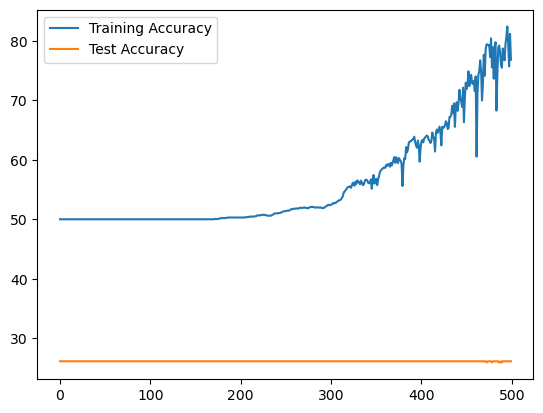

In [61]:
train_test(biLSTM, 500, batch_size, 0.1, pep_tensor_bcell, labels_tensor_bcell, pep_tensor_sars, labels_tensor_sars, updates=True)

The bidirectional LSTM was again able to pick up on patterns within the train set but not anything generalized to cover the SARS data. This is consistent with all of our models so far, further implying that there are patterns within the sars dataset that are unable to be picked up by the models trained on general bcell data. This means that the patterns within epitopes may truly be organism specific.

## LSTM with multi-head attention mechanism

Here, we will use a unidirectional LSTM with a multi-head attention mechanism. We hope that the matrix multiplication within the attention layer will give insight to both the peptide sequence as well as context from the protein sequence. The protein sequence will be our key and value while the peptide sequence will be our query.

In [76]:
# define our LSTM with attention
class LSTM_Attention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes) -> None:
        super(LSTM_Attention, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(20, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        # x shape -> (batch_size, seq_size, input_size)

        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 20),
            nn.Sigmoid(),
            nn.Linear(20, num_classes)
        )
    
    def forward(self, pep_seq, prot_seq):
        h0 = torch.zeros(self.num_layers, pep_seq.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, pep_seq.size(0), self.hidden_dim).to(device)

        peptide_lstm, _ = self.lstm(self.embedding(pep_seq), (h0,c0))
        protein_lstm, _ = self.lstm(self.embedding(prot_seq), (h0,c0))
        # out: batch_size, seq_length, hidden_dim

        #permutations for attention
        peptide_lstm = peptide_lstm.permute(1,0,2)
        protein_lstm = protein_lstm.permute(1,0,2)

        #attention
        out, _ = self.attention(peptide_lstm, protein_lstm, protein_lstm)
        # out (seq, N, 32)

        #back to original shape
        out = out.permute(1,0,2)

        # out (N, seq , 32)
        # take the last output of the LSTM
        out = out[:, -1, :]
        # out (N, 32)
        out = self.fc(out)
        return out

In [77]:
# instantiating our LSTM with attention
attn = LSTM_Attention(embedding_dim, hidden_dim, num_layers, num_classes).to(device)


In [80]:
# define our LSTM with attention
def train_test_attn(model, epochs, batch_size, learning_rate, pep_train, prot_train, label, pep_test, prot_test, label_test, updates=False):
    '''
    train and test for LSTM with attention
    '''

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    scores = pd.DataFrame()

    for epoch in range(epochs):
        loss_sum = 0
        acc_sum = 0
        acc_sum_test = 0
        for i in range(0, len(pep_train), batch_size):
            batch_pep = pep_train[i:i+batch_size]
            batch_prot = prot_train[i:i+batch_size]
            batch_label = label[i:i+batch_size]

            #forward
            optimizer.zero_grad()
            outputs = model(batch_pep, batch_prot)

            loss = criterion(outputs, batch_label)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

            predicted = torch.argmax(outputs, dim=1)
            acc_sum += (predicted == batch_label).sum().item() / len(batch_label)

        loss_avg = round((loss_sum / (len(pep_train) / batch_size)), 3)
        acc_avg = round((acc_sum / (len(pep_train) / batch_size)), 3)

        predicted_test = torch.argmax(model(pep_test, prot_test), dim=1)
        acc_sum_test += (predicted_test == label_test).sum().item() / len(label_test)
        acc_avg_test = round((acc_sum_test), 3)

        if updates == True:
            print(f'Epoch = {epoch+1}, loss = {loss_avg}, acc = {acc_avg*100}, test_acc = {acc_avg_test*100}')
        # scores.loc[epoch, "Epoch"] = epoch + 1
        scores.loc[epoch, 'Training Accuracy'] = acc_avg*100
        scores.loc[epoch, 'Test Accuracy'] = acc_avg_test*100

    scores.plot(kind='line')

    print('Finished Training')


Finished Training


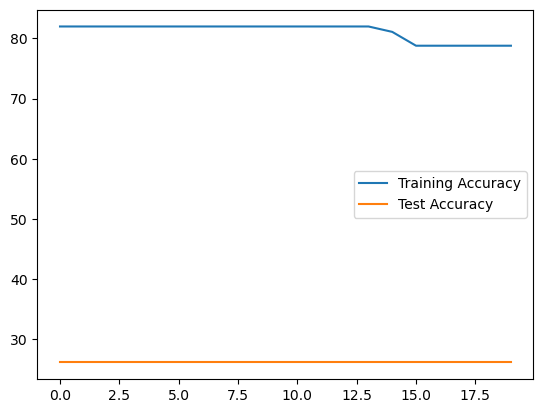

In [81]:
# training and testing LSTM with attention
train_test_attn(attn, 20, batch_size, learning_rate, pep_tensor_bcell, prot_tensor_bcell, labels_tensor_bcell, pep_tensor_sars, prot_tensor_sars, labels_tensor_sars)

wow! we see that the model is still unable to learn anything throughout the epochs. This may be due to problems with he we are setting up our model. For now, we conclude that this attention mechanism is unable to predict epitopes, even given the parent protein sequences as context.

## Neural network for protein and peptide features

Here, we will attempt to fit our numerical features to a neural network. We will use the same hyperparameters as above.

In [116]:
# simple neural network for numeric features
class Simple_NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes) -> None:
        super(Simple_NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
    def predict(self, x):
        out = self.forward(x)

        return torch.argmax(out, dim=1)

In [117]:
# defining a training and testing function for our simple neural network
def simple_train_test(model, num_epochs, lr, X_train, y_train, X_test, y_test, batch_size, updates=False):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scores = pd.DataFrame()

    for epoch in range(num_epochs):
        loss_sum = 0
        acc_sum = 0
        acc_sum_test = 0
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)

            loss = criterion(outputs, batch_y)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

            predicted = model.predict(batch_X)
            acc_sum += (predicted == batch_y).sum().item() / len(batch_y)

        loss_avg = round((loss_sum / (len(X_train) / batch_size)), 3)
        acc_avg = round((acc_sum / (len(X_train) / batch_size)), 3)

        predicted_test = model.predict(X_test)
        acc_sum_test = (predicted_test == y_test).sum().item() / len(y_test)
        acc_avg_test = round((acc_sum_test), 3)

        if updates == True:
            print(f'Epoch = {epoch+1}, loss = {loss_avg}, acc = {acc_avg*100}, test_acc = {acc_avg_test*100}')

        scores.loc[epoch, 'Training Accuracy'] = acc_avg*100
        scores.loc[epoch, 'Test Accuracy'] = acc_avg_test*100
    
    scores.plot(kind='line')
    print('Finished Training')

Now that we have our model and training function, we can load our combined dataset again and train our model on a training set of 80% and test on the remaining 20%. We will use the same hyperparameters as above.

In [119]:
from sklearn.model_selection import train_test_split

# setting features
features = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 
            'parent_hydrophobicity', 'parent_isoelectric_point', 'parent_aromaticity', 'parent_instability_index',
            'amino_acid_pro', 'amino_acid_tyr', 'start_position']

# X_train = df[features]
# X_test = df_test[features]
# y_train = df['antibody_activity']
# y_test = df_test['antibody_activity']

# load bcell/sars data
bcell_sars = pd.read_csv('data/bcell_sars_cleaned.csv')
X = bcell_sars[features]
y = bcell_sars['antibody_activity']

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# scale features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# convert to tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)



In [120]:
# instantiate model
input_dim = len(features)
simple_nn = Simple_NN(input_dim, hidden_dim, num_classes).to(device)

Epoch = 1, loss = 0.647, acc = 72.39999999999999, test_acc = 71.7
Epoch = 2, loss = 0.589, acc = 73.3, test_acc = 72.89999999999999
Epoch = 3, loss = 0.578, acc = 74.3, test_acc = 74.5
Epoch = 4, loss = 0.586, acc = 74.1, test_acc = 74.6
Epoch = 5, loss = 0.549, acc = 75.2, test_acc = 74.7
Epoch = 6, loss = 0.554, acc = 75.1, test_acc = 74.1
Epoch = 7, loss = 0.573, acc = 74.7, test_acc = 74.9
Epoch = 8, loss = 0.569, acc = 74.6, test_acc = 75.9
Epoch = 9, loss = 0.55, acc = 75.3, test_acc = 75.2
Epoch = 10, loss = 0.552, acc = 75.1, test_acc = 75.8
Epoch = 11, loss = 0.549, acc = 75.3, test_acc = 75.7
Epoch = 12, loss = 0.556, acc = 74.7, test_acc = 75.1
Epoch = 13, loss = 0.552, acc = 74.5, test_acc = 75.2
Epoch = 14, loss = 0.555, acc = 74.4, test_acc = 76.3
Epoch = 15, loss = 0.546, acc = 74.7, test_acc = 75.9
Epoch = 16, loss = 0.545, acc = 74.6, test_acc = 75.1
Epoch = 17, loss = 0.542, acc = 74.8, test_acc = 76.5
Epoch = 18, loss = 0.542, acc = 74.7, test_acc = 75.8
Epoch = 19, 

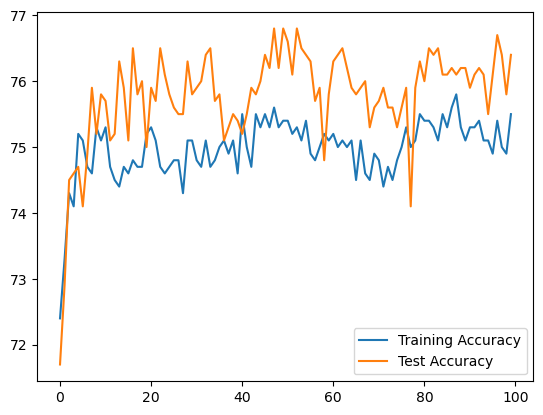

In [121]:
# train and test model
simple_train_test(simple_nn, 100, 0.3, X_train, y_train, X_test, y_test, batch_size, updates=True)

The simple neural network still does not pick up any patterns within our data. This means that we might really need to figure out a way to extract patterns through experimenting further with more deep learning models.

## Conclusion

We have tried many different deep learning models to try and predict bcell epitopes. We have tried a simple RNN, LSTM, LSTM with sigmoid, bidirectional LSTM, LSTM with multi-head attention mechanism, and a simple neural network. None of these models were able to pick up on any patterns within our data. This means that we will need to try and figure out a way to extract patterns from our data. There have been studies that have found success with bidirectional LSTMs with an attention mechanism. This is one direction in which we will go in future iterations of this project. In the future, we may also try to use a transformer model. Next steps would also include using pre-trained protein embeddings or utilizing pre-trained models such as proteinBERT or ProtTrans. We may also try to extract more data from different viruses such as influenza. There is much more work to be done and this is just the start of this project.